In [1]:
#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

#fourier
from scipy.fft import fft, ifft
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

#metrics en cv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import TimeSeriesSplit

#regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

SEED = 1337
test_df = pd.read_csv('test.csv', parse_dates=['date_hour'])
train_df = pd.read_csv('train.csv', parse_dates=['date_hour'])

In [2]:
#functies
def highlight_min(s, props=''):
    """Dit functie highlight het laagste waarde van elk kolom.
    Maak gebruik van DataFrame.style.apply().
    
    Parameters:
    -----------
    s: DataFrame, the dataframe to highlight on.
    
    props: str, the color and background color.
    
    Returns:
    np.where(s == np.nanmin(s.values), props, ''): the DataFrame with highlights.
    --------
    
    """
    return np.where(s == np.nanmin(s.values), props, '')

In [3]:
models_dict = {'lr': [LinearRegression(), {}],
               'dt': [DecisionTreeRegressor(random_state=SEED), {'max_depth': [10, 20, 30, None]}],
               'rf': [RandomForestRegressor(n_jobs=-1, random_state=SEED), {'max_depth': [10, 20, 30, None]}],
               'gb': [GradientBoostingRegressor(random_state=SEED), {'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
                                                                     'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5]}]}

In [4]:
#classes
class date_time_resample:
    def __init__(self, data):
        self.dfh = data.set_index('date_hour')
        self.dfh.resample('H').agg({'holiday': np.mean, 'weathersit': np.mean,
                                    'temp': np.mean, 'hum': np.mean, 'windspeed': np.mean})
        self.dfh = self.dfh.reset_index()
        self.dfh['hour'] = self.dfh['date_hour'].dt.hour
        self.dfh['DayName'] = self.dfh['date_hour'].dt.day_name()
        self.dfh['week'] = self.dfh['date_hour'].dt.isocalendar().week
        self.dfh['month'] = self.dfh['date_hour'].dt.month
        self.dfh['year'] = self.dfh['date_hour'].dt.year

        def season(month):
            if month in [3, 4, 5]:
                return 1
            elif month in [6, 7, 8]:
                return 2
            elif month in [9, 10, 11]:
                return 3
            else:
                return 4
        self.dfh['season'] = self.dfh['month'].apply(season)
        self.dfh.set_index('date_hour', inplace=True)     
class RegressionModels:
    def __init__(self, data, target, dummie_cols=False, shuffle=True, test_size=0.2, random_state=1337, drop=False):
        self.data = data
        if drop:
            self.data = self.data.drop(drop, axis=1)
        if dummie_cols:
            self.data = pd.get_dummies(self.data, columns=dummie_cols)
        self.X = self.data.drop(target, axis=1)
        self.y = self.data[[target]]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, shuffle=shuffle)

    def DeterministicProcess(self, order, fourier_terms=False, constant=False, drop=True):
        if fourier_terms:
            self.fourier_list = []
            for term in fourier_terms:
                self.fourier_list.append(CalendarFourier(freq=term[0], order=term[1]))
        else:
            self.fourier_list = ()

        dp = DeterministicProcess(
            index=self.y_train.index,
            constant=constant,
            order=order,
            drop=drop,
            additional_terms=self.fourier_list
        )

        self.X_train2 = dp.in_sample()

        self.X_test2 = dp.out_of_sample(steps=len(self.y_test), forecast_index=self.y_test.index)

    def concat(self):
        self.X_train = pd.concat([self.X_train, self.X_train2], axis=1)

        self.X_test = pd.concat([self.X_test, self.X_test2], axis=1)
    
    def tune_params(self, n_splits, models_dict):

        self.models_dict = models_dict
        self.results = {}
        self.best_model = None
        self.best_params = None
        self.best_score = 0

        kf = TimeSeriesSplit(n_splits=n_splits)

        for model_name, (model, param_grid) in models_dict.items():
            model_cv = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, n_jobs=-1)
            model_cv.fit(self.X_train, self.y_train)
            self.results[model_name] = [model_cv.best_params_, model_cv.best_score_]
            if model_cv.best_score_ > self.best_score:
                self.best_score = model_cv.best_score_
                self.best_model = model_name
                self.best_params = model_cv.best_params_  

    def predict(self, models=models_dict):
        self.fi = {}
        self.model = self.models_dict[self.best_model][0].set_params(**self.best_params)
        print('fit_predict', self.model)
        self.model.fit(self.X_train, self.y_train)
        self.y_test_pred = self.model.predict(self.X_test)
        self.y_train_pred = self.model.predict(self.X_train)
        print(f'train r2 {self.model}', r2_score(self.y_train, self.y_train_pred))
        print(f'test r2 {self.model}', r2_score(self.y_test, self.y_test_pred))
        if hasattr(self.model, 'feature_importances_'):
            self.fi[self.best_model] = self.model.feature_importances_

    def feature_imp(self):
        for model_name, importances in self.fi.items():
            # Create a DataFrame with feature names and their importance scores.
            feature_importance = pd.DataFrame(importances)
            cols = pd.DataFrame(self.X_train.columns)
            df_fi = pd.concat([cols, feature_importance], axis=1)
            df_fi.columns = ['feature', 'importance']
            # Sort the DataFrame by the importance scores.
            df_fi.sort_values('importance', ascending=True, inplace=True)
            # Plot the feature importances.
            df_fi.plot(kind='barh', x='feature', y='importance', title=model_name)
        

In [5]:
dfh_test = date_time_resample(data=test_df)
dfh_train = date_time_resample(data=train_df)
display(dfh_test.dfh)
display(dfh_train.dfh)

,holiday,weathersit,temp,atemp,hum,windspeed,hour,DayName,week,month,year,season
date_hour,,,,,,,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,0,Saturday,48,12,2012,4
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,1,Saturday,48,12,2012,4
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2,Saturday,48,12,2012,4
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,3,Saturday,48,12,2012,4
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,4,Saturday,48,12,2012,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881,19,Wednesday,51,12,2012,4
2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239,20,Wednesday,51,12,2012,4
2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239,21,Wednesday,51,12,2012,4


,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,DayName,week,month,year,season
date_hour,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,0,Saturday,52,1,2011,4
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,Saturday,52,1,2011,4
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2,Saturday,52,1,2011,4
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,3,Saturday,52,1,2011,4
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,4,Saturday,52,1,2011,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,Friday,48,11,2012,3
2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,Friday,48,11,2012,3
2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,Friday,48,11,2012,3


C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'lr': [{}, -321.59711048409287], 'dt': [{'max_depth': 30}, 0.5637698106005811], 'rf': [{'max_depth': None}, 0.7351598222886219], 'gb': [{'learning_rate': 0.2, 'loss': 'squared_error'}, 0.6687705305838361]} rf 0.7351598222886219 {'max_depth': None}
fit_predict RandomForestRegressor(n_jobs=-1, random_state=1337)


C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


train r2 RandomForestRegressor(n_jobs=-1, random_state=1337) 0.9894014841090074
test r2 RandomForestRegressor(n_jobs=-1, random_state=1337) 0.4220112457406696


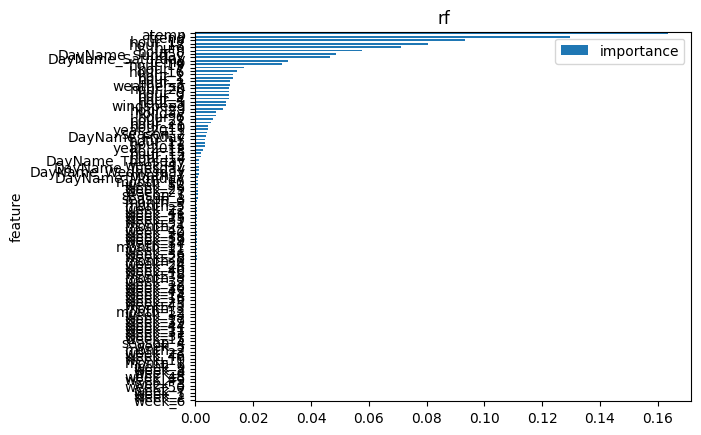

In [6]:
data = RegressionModels(data=dfh_train.dfh, dummie_cols=['hour', 'DayName', 'week', 'month', 'year', 'season'], target='cnt', shuffle=False, test_size=7*24)
data.DeterministicProcess(order=1)
data.concat()
data.tune_params(n_splits=52, models_dict=models_dict)
print(data.results, data.best_model, data.best_score, data.best_params)
data.predict()
data.feature_imp()

## EDA

In [14]:
display(dfh_test.dfh.info())
display(dfh_train.dfh.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456 entries, 2012-12-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     456 non-null    int64  
 1   weathersit  456 non-null    int64  
 2   temp        456 non-null    float64
 3   atemp       456 non-null    float64
 4   hum         456 non-null    float64
 5   windspeed   456 non-null    float64
 6   hour        456 non-null    int64  
 7   DayName     456 non-null    object 
 8   week        456 non-null    UInt32 
 9   month       456 non-null    int64  
 10  year        456 non-null    int64  
 11  season      456 non-null    int64  
dtypes: UInt32(1), float64(4), int64(6), object(1)
memory usage: 45.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16637 entries, 2011-01-01 00:00:00 to 2012-11-30 23:00:00
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     16637 non-null  int64  
 1   weathersit  16637 non-null  int64  
 2   temp        16637 non-null  float64
 3   atemp       16637 non-null  float64
 4   hum         16637 non-null  float64
 5   windspeed   16637 non-null  float64
 6   cnt         16637 non-null  int64  
 7   hour        16637 non-null  int64  
 8   DayName     16637 non-null  object 
 9   week        16637 non-null  UInt32 
 10  month       16637 non-null  int64  
 11  year        16637 non-null  int64  
 12  season      16637 non-null  int64  
dtypes: UInt32(1), float64(4), int64(7), object(1)
memory usage: 1.7+ MB


None

#### alle features zijn numeriek behalve de day name

In [15]:
display(dfh_test.dfh.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0))
display(dfh_train.dfh.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0))

,holiday,weathersit,temp,atemp,hum,windspeed,hour,week,month,year,season
count,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000
mean,0.000000,1.592105,0.360132,0.363691,0.714868,0.157639,11.500000,49.578947,12.000000,2012.000000,4.000000
std,0.000000,0.607882,0.079432,0.076354,0.177732,0.106499,6.929789,0.878508,0.000000,0.000000,0.000000
min,0.000000,1.000000,0.160000,0.181800,0.330000,0.000000,0.000000,48.000000,12.000000,2012.000000,4.000000
25%,0.000000,1.000000,0.300000,0.303000,0.560000,0.089600,5.750000,49.000000,12.000000,2012.000000,4.000000
50%,0.000000,2.000000,0.360000,0.363600,0.750000,0.134300,11.500000,50.000000,12.000000,2012.000000,4.000000
75%,0.000000,2.000000,0.400000,0.409100,0.870000,0.223900,17.250000,50.000000,12.000000,2012.000000,4.000000
max,0.000000,3.000000,0.600000,0.621200,1.000000,0.492500,23.000000,51.000000,12.000000,2012.000000,4.000000


,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,week,month,year,season
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009,11.547875,25.614895,6.294164,2011.480375,2.417683
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755,6.914199,14.466678,3.310969,0.499630,1.092734
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2011.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000,6.000000,13.000000,3.000000,2011.000000,1.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000,12.000000,26.000000,6.000000,2011.000000,2.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000,18.000000,38.000000,9.000000,2012.000000,3.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000,23.000000,52.000000,12.000000,2012.000000,4.000000


In [16]:
print(dfh_train.dfh.isna().sum())
print(dfh_test.dfh.isna().sum())

holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
hour          0
DayName       0
week          0
month         0
year          0
season        0
dtype: int64
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
hour          0
DayName       0
week          0
month         0
year          0
season        0
dtype: int64


holiday      -0.026586
weathersit   -0.140111
temp          0.409245
atemp         0.404820
hum          -0.327288
windspeed     0.097006
cnt           1.000000
hour          0.396945
week          0.130888
month         0.140023
year          0.266739
season       -0.145945
Name: cnt, dtype: float64


C:\Users\akers\AppData\Local\Temp\ipykernel_21516\1940348218.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(dfh_train.dfh.corr()['cnt'])


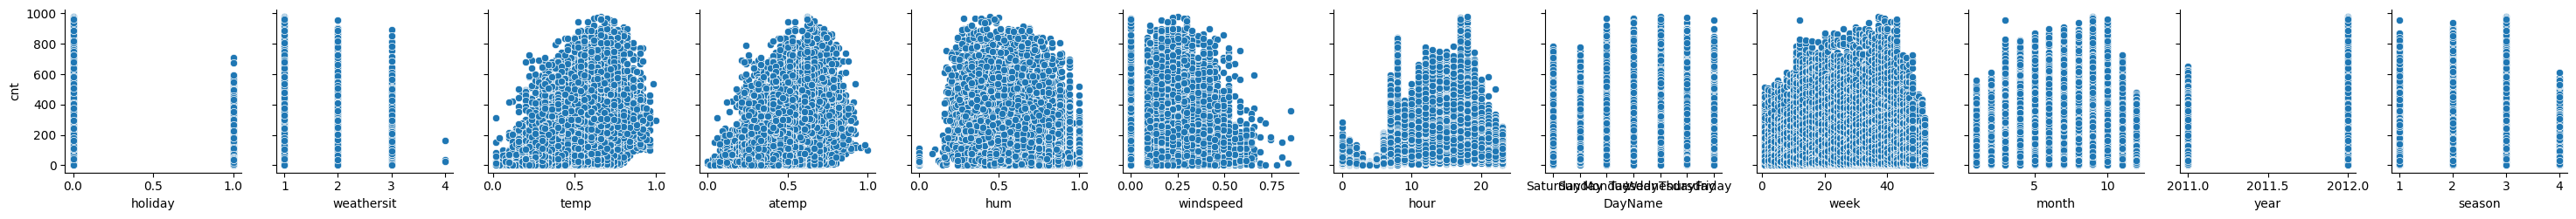

In [17]:
x_cols = dfh_train.dfh.columns.drop('cnt')
print(dfh_train.dfh.corr()['cnt'])
fig = sns.pairplot(
    dfh_train.dfh,
    x_vars=x_cols,
    y_vars='cnt'
)
plt.show()

In [21]:
models_dict = {'lr': [LinearRegression(), {}],
               'dt': [DecisionTreeRegressor(random_state=SEED), {'max_depth': [30]}],
               'rf': [RandomForestRegressor(n_jobs=-1, random_state=SEED), {'max_depth': [30]}],
               'gb': [GradientBoostingRegressor(random_state=SEED), {'loss': ['squared_error'],
                                                                     'learning_rate': [0.1]}]}

C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'lr': [{}, -1314.5710898166121], 'dt': [{'max_depth': 30}, 0.6832300356235629], 'rf': [{'max_depth': 30}, 0.8162038027177771], 'gb': [{'learning_rate': 0.1, 'loss': 'squared_error'}, 0.7004858552904322]} rf 0.8162038027177771 {'max_depth': 30}
fit_predict RandomForestRegressor(max_depth=30, n_jobs=-1, random_state=1337)


C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


train r2 RandomForestRegressor(max_depth=30, n_jobs=-1, random_state=1337) 0.9931840456736845
test r2 RandomForestRegressor(max_depth=30, n_jobs=-1, random_state=1337) 0.32240510185773497


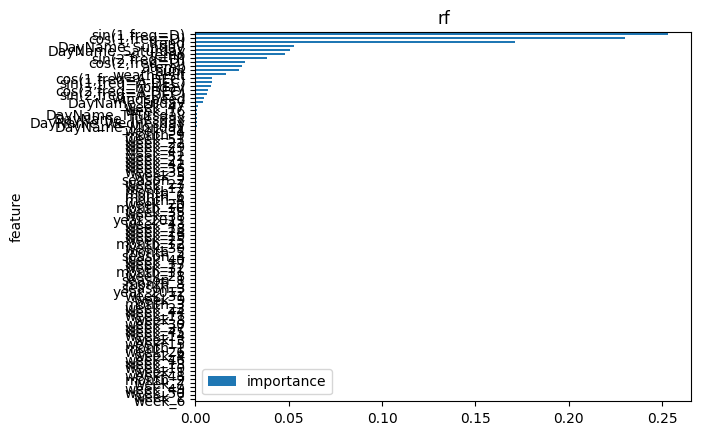

In [22]:
data = RegressionModels(data=dfh_train.dfh, dummie_cols=['DayName', 'week', 'month', 'year', 'season'],drop='hour' ,target='cnt', shuffle=False, test_size=7*24)
data.DeterministicProcess(order=1, fourier_terms=[('A', 2), ('D', 2)])
data.concat()
data.tune_params(n_splits=52, models_dict=models_dict)
print(data.results, data.best_model, data.best_score, data.best_params)
data.predict()
data.feature_imp()

C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'lr': [{}, -81.18894765062525], 'dt': [{'max_depth': 10}, 0.6978306546250121], 'rf': [{'max_depth': None}, 0.814013311630571], 'gb': [{'learning_rate': 0.2, 'loss': 'squared_error'}, 0.7005607437022531]} rf 0.814013311630571 {'max_depth': None}
fit_predict RandomForestRegressor(n_jobs=-1, random_state=1337)


C:\Users\akers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


train r2 RandomForestRegressor(n_jobs=-1, random_state=1337) 0.993193451813753
test r2 RandomForestRegressor(n_jobs=-1, random_state=1337) 0.29540309562162637


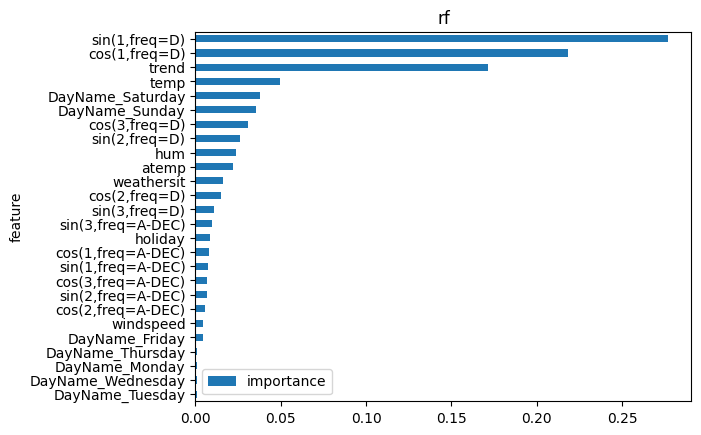

In [7]:
data = RegressionModels(data=dfh_train.dfh, dummie_cols=['DayName'],drop=['hour', 'week', 'month', 'year', 'season'] ,target='cnt', shuffle=False, test_size=7*24)
data.DeterministicProcess(order=1, fourier_terms=[('A', 3), ('D', 3)])
data.concat()
data.tune_params(n_splits=52, models_dict=models_dict)
print(data.results, data.best_model, data.best_score, data.best_params)
data.predict()
data.feature_imp()